# Introduction

This notebook will go through the steps to undertake a classification using a segmentation rather than a pixel based classification.

A number of studies have proposed that segmenting an image and classifying the segments can produce a better classification result than classifying individual pixels.

The notebook will go through the following steps:

Perform segmentation
Populate segments with data
Extract sample data
Split sample data into training, testing and validation sets
Training Classifier
Apply Classifier
Running Notebook
The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense.

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

### Jupyter-lab:

> Edit > 'Clear All Outputs'

### Jupyter-notebook:

> Cell > 'All Outputs' > Clear

### Fuente: 

Código adaptado de RSGISLib Tutorials
Repositorio: https://github.com/remotesensinginfo/rsgislib-tutorials
Segmentación: https://github.com/remotesensinginfo/rsgislib-tutorials/blob/main/03_intro_image_classification/02_segment_ml_classification.ipynb

In [1]:
# Import modules from python standard library
import os
import pprint
import random

# Import the matplotlib plotting module and set it to work within
# a notebook environment.

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classratutils
import rsgislib.classification.classsklearn
import rsgislib.rastergis
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.vectorutils
import rsgislib.vectorutils.createrasters
import rsgislib.zonalstats
from rsgislib.segmentation import shepherdseg
from sklearn.ensemble import RandomForestClassifier

# Import the geopandas module
os.environ["USE_PYGEOS"] = "0"
import geopandas

# Import the numpy module
import numpy

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

Image Data Size: 2105 x 2403


/Users/felipehernandez/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


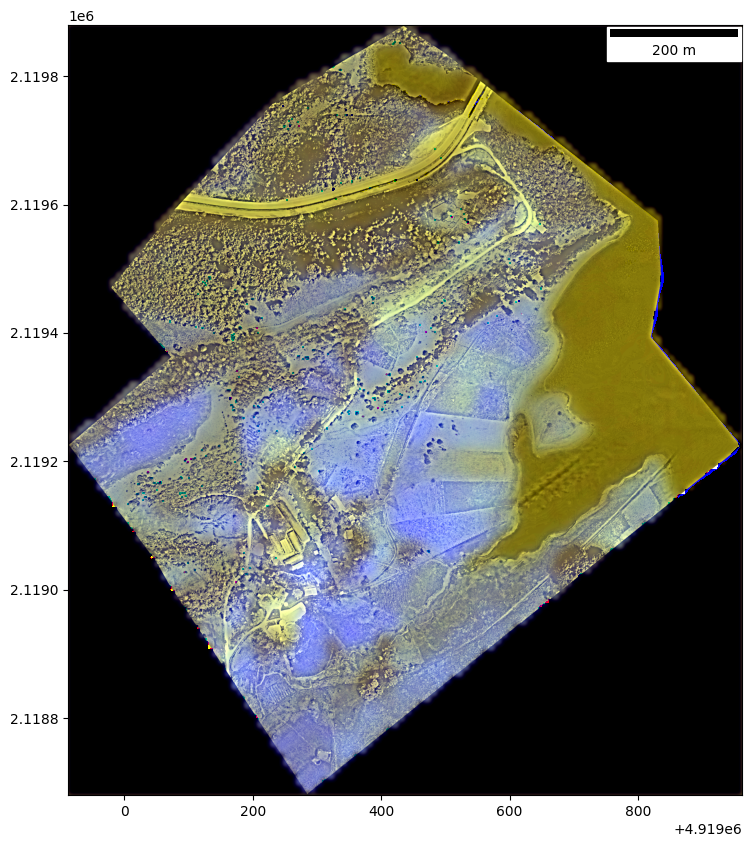

In [2]:
input_img = "/Users/felipehernandez/Documents/Natalia/Desarrollo/Repos/data/fusion_satelite_uav/processed_images/uas_05m/wavelet/RGB832/WAV_2022_10_RGB832_uas_05m.tif"

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image data using bands 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]

rsgislib.tools.mapping.create_raster_img_map(ax, 
                                             input_img, 
                                             img_bands=[3, 2, 1], 
                                             img_stch=rsgislib.IMG_STRETCH_STDEV)

In [4]:
out_clumps_img = "WAV_2022_10_RGB832_uas_05m_segs.kea"
out_mean_img = "WAV_2022_10_RGB832_uas_05m_meanimg.kea"
tmp_dir = "tmp"

shepherdseg.run_shepherd_segmentation(
    input_img,
    out_clumps_img,
    out_mean_img,
    tmp_dir,
    gdalformat="KEA",  # Output file format
    calc_stats=True,  # Calculate statistics on the output images
    no_stretch=False,  # Normalise the input bands by applying a 2 standard devation stretch
    no_delete=False,  # Delete the temporary files created during the processing
    num_clusters=60,  # The number of clusters (k) for the initial kMeans clustering
    min_n_pxls=100,  # Minimum number of pixels within a clump (segment)
    dist_thres=100,
    bands=[3, 2, 1],  # Just use bands 8 (NIR), 9 (SWIR) and 3 (Red)
    sampling=100,  # Speed up the kMeans clustering by only using every 100th pixel.
    km_max_iter=200,  # Maximum number of kMeans iterations
    process_in_mem=True,  # Do the process using in-memory datasets rather than to disk
    save_process_stats=False,
    img_stretch_stats="",
    kmeans_centres="",
    img_stats_json_file="",
)

Subsetting the image bands
Stretch Input ImageNew image width = 2105 height = 2403 bands = 3




Band[1] Min = 0 Mean = 16.3813681542 (Std Dev = 15.5351002837) max = 255
Band[2] Min = 0 Mean = 18.3418961379 (Std Dev = 16.9518610634) max = 255
Band[3] Min = 0 Mean = 37.3621112603 (Std Dev = 41.4015725541) max = 255
New image width = 2105 height = 2403 bands = 3

Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.
New image width = 2105 height = 2403 bands = 3

Mask stretched Image.
Image: tmp/WAV_2022_10_RGB832_uas_05m_bselect.kea
	 Variable 'b1' is band 1
New image width = 2105 height = 2403 bands = 1

New image width = 2105 height = 2403 bands = 3

Deleting file: tmp/WAV_2022_10_RGB832_uas_05m_stchdonly.kea
Deleting file: tmp/WAV_2022_10_RGB832_uas_05m_stchdonly_off.kea
Deleting file: tmp/WAV_2022_10_RGB832_uas_05m_stchdmaskonly.kea
Performing KMeans.
inputImage = tmp/WAV_2022_10_RGB832_uas_05m_stchd.kea
outputMatrixFile =

In [6]:
import rsgislib.vectorutils.createvectors

segs_vec_file = "WAV_2022_10_RGB832_uas_05m_segs.gpkg"
segs_vec_lyr = "WAV_2022_10_RGB832_uas_05m_segs"

rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=segs_vec_file,  # The output vector file name and path
    out_vec_lyr=segs_vec_lyr,  # The output vector layer name
    out_format="GPKG",  # The output vector format
    input_img=out_clumps_img,  # The input segmentation image
    img_band=1,  # The band within the input image
    mask_img=out_clumps_img,  # A mask image (usually the same as the input image)
    mask_band=1,  # The band within the mask image
)

  7%|███                                        | 7/100 [00:00<00:01, 63.98it/s]

Polygonising...


101it [00:07, 13.27it/s]                                                        

Completed


In [7]:
bs = []
bs.append(rsgislib.rastergis.BandAttStats(band=1, mean_field="blue_refl"))
bs.append(rsgislib.rastergis.BandAttStats(band=2, mean_field="green_refl"))
bs.append(rsgislib.rastergis.BandAttStats(band=3, mean_field="nir_b8_refl"))
rsgislib.rastergis.populate_rat_with_stats(input_img, out_clumps_img, bs)

In [8]:
# Create Training Rasterise tmp directory
tmp_train_dir = "train_tmp"
if not os.path.exists(tmp_train_dir):
    os.mkdir(tmp_train_dir)

vec_train_file = "/Users/felipehernandez/Documents/entrenamiento.gpkg"

# Define Training Data
class_vec_sample_clumps_info = list()

# Define the file name of the samples HDF5 file, which will be created
pastos_limpios_clumps_h5 = "pastos_limpios_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="pastos_limpios",
        vec_file=vec_train_file,
        vec_lyr="pastos_limpios",
        file_h5=pastos_limpios_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
pastos_espacios_naturales_clumps_h5 = "pastos_espacios_naturales_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="pastos_espacios_naturales",
        vec_file=vec_train_file,
        vec_lyr="pastos_espacios_naturales",
        file_h5=pastos_espacios_naturales_clumps_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
lagunas_lagos_cienagas_naturales_clumps_h5 = "lagunas_lagos_cienagas_naturales_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="lagunas_lagos_cienagas_naturales",
        vec_file=vec_train_file,
        vec_lyr="lagunas_lagos_cienagas_naturales",
        file_h5=lagunas_lagos_cienagas_naturales_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
arbustal_clumps_h5 = "arbustal_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="arbustal",
        vec_file=vec_train_file,
        vec_lyr="arbustal",
        file_h5=arbustal_clumps_h5,
    )
)

rsgislib.classification.classratutils.populate_clumps_with_class_training(
    out_clumps_img,
    class_vec_sample_clumps_info,
    tmp_train_dir,
    classes_int_col="class_int_smpls",
    classes_name_col="class_name_smpls",
)


Creating output image using input image
Running Rasterise now...
Writing Stats (Mean, ) to Output RAT

Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

New image width = 2105 height = 2403 bands = 1

Opening Clumps Image: WAV_2022_10_RGB832_uas_05m_segs.kea
Opening Input Image: train_tmp/CombinedClasses_a19fa12fe6.kea


Min 0
Max 4
Range 5
[0, 1, 2, 3, 4]



In [9]:
# Columns to be extracted and used for classification
cols = [
    "blue_refl",
    "green_refl",
    "nir_b8_refl"
]

# Reading classification column from RAT.
class_int_smpls_col = rsgislib.rastergis.get_column_data(out_clumps_img, "class_int_smpls")
# Get the unique classes (i.e., there are samples for the class)
unq_classes = numpy.unique(class_int_smpls_col)

cls_smpls_clumps_info = dict()

# Loop through each of the classes to extract the samples to a HDF5
for class_vec_sample in class_vec_sample_clumps_info:
    print("{}:".format(class_vec_sample.class_name))
    # Check the class is within the list of unique classes
    if class_vec_sample.id in unq_classes:
        # Extract the class samples to a HDF5 file
        rsgislib.classification.classratutils.extract_rat_col_data(
            out_clumps_img,
            cols,
            "class_int_smpls",
            class_vec_sample.id,
            class_vec_sample.file_h5,
            datatype=rsgislib.TYPE_32FLOAT,
        )
        cls_smpls_clumps_info[
            class_vec_sample.class_name
        ] = rsgislib.classification.ClassSimpleInfoObj(
            id=class_vec_sample.id, file_h5=class_vec_sample.file_h5
        )

pastos_limpios:
n feats: 97
n cols: 3
pastos_espacios_naturales:
n feats: 98
n cols: 3
lagunas_lagos_cienagas_naturales:
n feats: 33
n cols: 3
arbustal:
n feats: 91
n cols: 3


In [10]:
class_vec_sample_pixels_info = list()

# Define the file name of the samples HDF5 file, which will be created
pastos_limpios_pixels_h5 = "pastos_limpios_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="pastos_limpios",
        vec_file=vec_train_file,
        vec_lyr="pastos_limpios",
        file_h5=pastos_limpios_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
pastos_espacios_naturales_pixels_h5 = "pastos_espacios_naturales_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="pastos_espacios_naturales",
        vec_file=vec_train_file,
        vec_lyr="pastos_espacios_naturales",
        file_h5=pastos_espacios_naturales_pixels_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
lagunas_lagos_cienagas_naturales_pixels_h5 = "lagunas_lagos_cienagas_naturales_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="lagunas_lagos_cienagas_naturales",
        vec_file=vec_train_file,
        vec_lyr="lagunas_lagos_cienagas_naturales",
        file_h5=lagunas_lagos_cienagas_naturales_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
arbustal_pixels_h5 = "arbustal_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="arbustal",
        vec_file=vec_train_file,
        vec_lyr="arbustal",
        file_h5=arbustal_pixels_h5,
    )
)

img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[3, 2, 1]
    )
)

cls_smpls_pixel_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_pixels_info, tmp_train_dir, ref_img=input_img
)

Creating output image using input image
Writing Stats to RAT

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




In [11]:
print("Number of Samples:")
cls_smpls_info = dict()
for class_name in cls_smpls_pixel_info:
    h5_files = [cls_smpls_pixel_info[class_name].file_h5]
    if class_name in cls_smpls_clumps_info:
        h5_files.append(cls_smpls_clumps_info[class_name].file_h5)

    out_file_h5 = cls_smpls_pixel_info[class_name].file_h5.replace("_pixels", "")
    rsgislib.zonalstats.merge_extracted_hdf5_data(
        h5_files, out_file_h5, datatype=rsgislib.TYPE_32FLOAT
    )
    cls_smpls_info[class_name] = rsgislib.classification.ClassSimpleInfoObj(
        id=cls_smpls_pixel_info[class_name].id,
        file_h5=out_file_h5,
        blue=cls_smpls_pixel_info[class_name].blue,
        green=cls_smpls_pixel_info[class_name].green,
        red=cls_smpls_pixel_info[class_name].red,
    )

    print(
        "\t{}: {}".format(
            class_name, rsgislib.classification.get_num_samples(out_file_h5)
        )
    )

Number of Samples:
	pastos_limpios: 197
	pastos_espacios_naturales: 198
	lagunas_lagos_cienagas_naturales: 133
	arbustal: 191


In [12]:
cls_smpls_info["pastos_limpios"].red = 190
cls_smpls_info["pastos_limpios"].green = 192
cls_smpls_info["pastos_limpios"].blue = 146

cls_smpls_info["pastos_espacios_naturales"].red = 44
cls_smpls_info["pastos_espacios_naturales"].green = 168
cls_smpls_info["pastos_espacios_naturales"].blue = 128

cls_smpls_info["lagunas_lagos_cienagas_naturales"].red = 109
cls_smpls_info["lagunas_lagos_cienagas_naturales"].green = 219
cls_smpls_info["lagunas_lagos_cienagas_naturales"].blue = 215

cls_smpls_info["arbustal"].red = 137
cls_smpls_info["arbustal"].green = 214
cls_smpls_info["arbustal"].blue = 49

In [13]:
smpls_dir = "cls_smpls"
if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)

cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 10, 10, 100
)

0=1: (Train:cls_smpls/pastos_limpios_smpls_train.h5, Test:cls_smpls/pastos_limpios_smpls_test.h5, Valid:cls_smpls/pastos_limpios_smpls_valid.h5), (190, 192, 146)
1=2: (Train:cls_smpls/pastos_espacios_naturales_smpls_train.h5, Test:cls_smpls/pastos_espacios_naturales_smpls_test.h5, Valid:cls_smpls/pastos_espacios_naturales_smpls_valid.h5), (44, 168, 128)
2=3: (Train:cls_smpls/lagunas_lagos_cienagas_naturales_smpls_train.h5, Test:cls_smpls/lagunas_lagos_cienagas_naturales_smpls_test.h5, Valid:cls_smpls/lagunas_lagos_cienagas_naturales_smpls_valid.h5), (109, 219, 215)
3=4: (Train:cls_smpls/arbustal_smpls_train.h5, Test:cls_smpls/arbustal_smpls_test.h5, Valid:cls_smpls/arbustal_smpls_valid.h5), (137, 214, 49)


In [14]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100],
        "max_depth": [4, 8, 10, 12],
    },
)

sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

Training data size: 40 x 3
Best score was 0.475 and has parameters {'max_depth': 10, 'n_estimators': 20}.


In [15]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 400 x 3
Testing data size: 40 x 3
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 99.25%
Classifier Test Score = 57.5%


(0.9925, 0.575)

In [16]:
rsgislib.classification.classsklearn.apply_sklearn_classifier_rat(
    out_clumps_img,
    cols,
    sk_classifier,
    cls_smpls_fnl_info,
    out_col_int="class_id",
    out_col_str="class_names",
)

In [17]:
out_cls_img = "uas_05m_clumps_cls_rslt.kea"

rsgislib.classification.collapse_classes(
    out_clumps_img,
    out_cls_img,
    gdalformat="KEA",
    class_col="class_names",
    class_int_col="class_id",
)

Opening an image
Find the class names...

4:	 arbustal: [137,214,49]
3:	 lagunas_lagos_cienagas_naturales: [109,219,215]
2:	 pastos_espacios_naturales: [44,168,128]
1:	 pastos_limpios: [190,192,146]
New image width = 2105 height = 2403 bands = 1



Image Data Size: 2105 x 2403


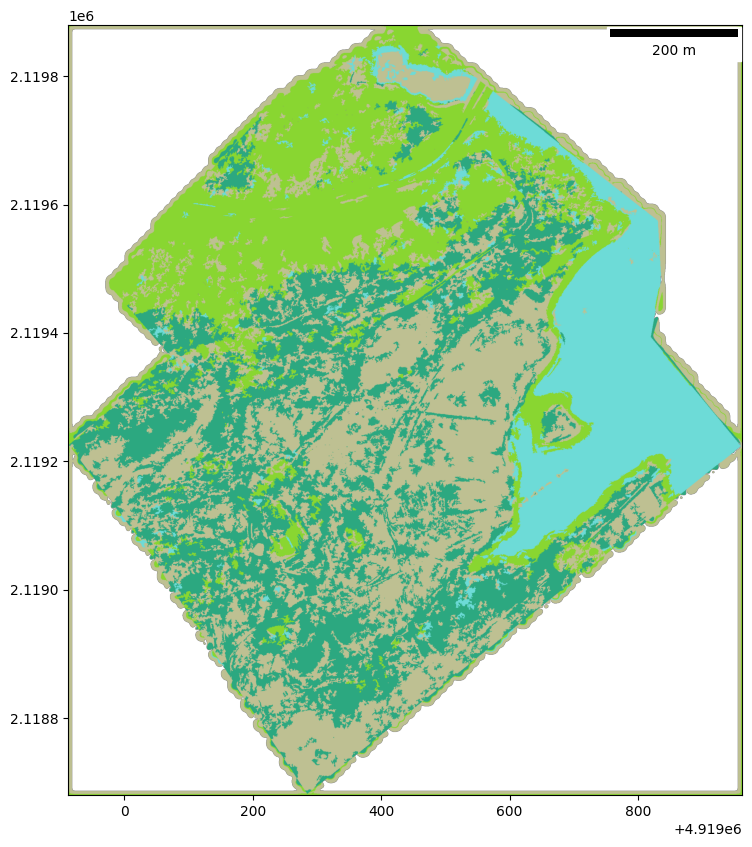

In [18]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_thematic_raster_map(ax, out_cls_img)

In [19]:
cls_info = rsgislib.tools.plotting.create_legend_info_dict(
    out_cls_img,
    cls_names_col="class_names",
    use_title_case=True,
    underscore_to_space=True,
)


In [20]:
out_cls_img_1 = "uas_05m_clumps_cls_rslt.tif"

rsgislib.classification.collapse_classes(
    out_clumps_img,
    out_cls_img_1,
    gdalformat="GTiff",
    class_col="class_names",
    class_int_col="class_id",
)

Opening an image
Find the class names...

4:	 arbustal: [137,214,49]
3:	 lagunas_lagos_cienagas_naturales: [109,219,215]
2:	 pastos_espacios_naturales: [44,168,128]
1:	 pastos_limpios: [190,192,146]
New image width = 2105 height = 2403 bands = 1



Image Data Size: 2105 x 2402
Image Data Size: 2105 x 2402
Max. characters in class name: 32
Column width: 204
Image: 420 x  58


/Users/felipehernandez/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


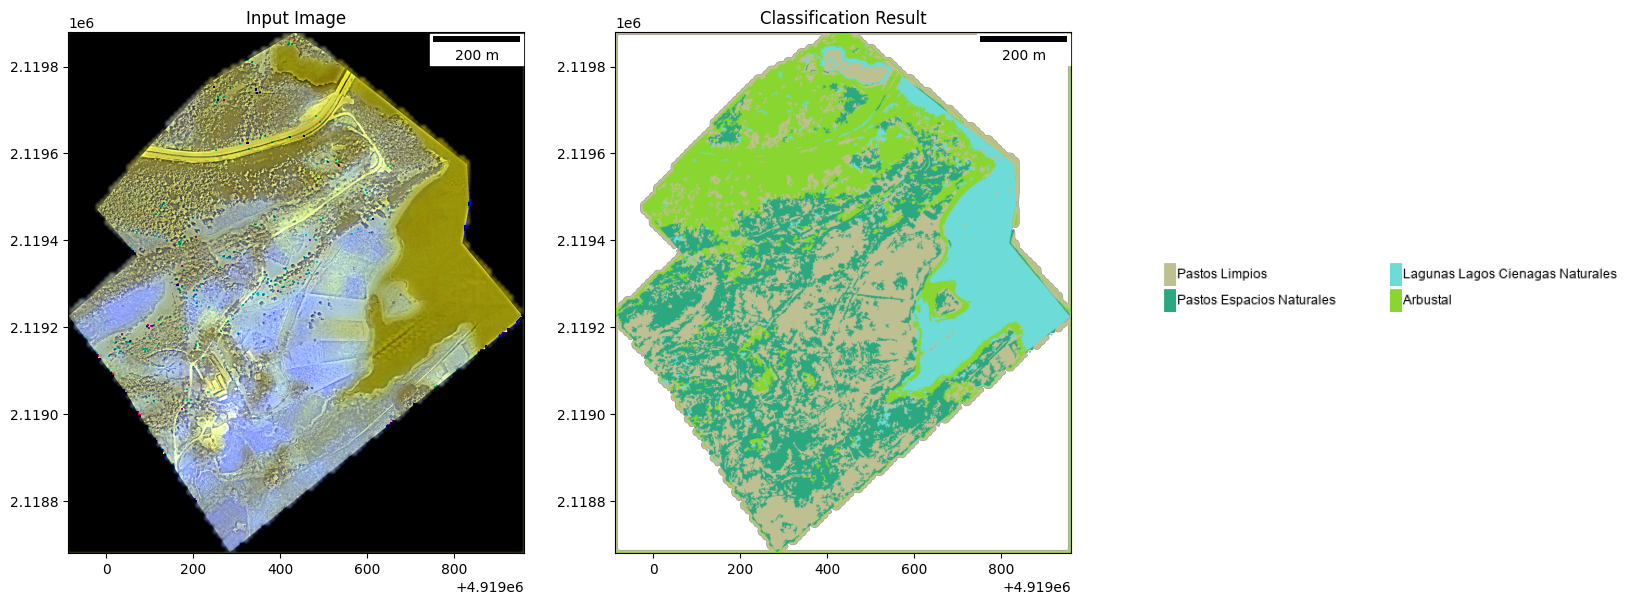

In [21]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [0, 4919962, 0, 2119879]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
# Add the Sentinel-2 image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[3, 2, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.title.set_text("Input Image")

# Add the classification to the second axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result")

rsgislib.tools.plotting.create_legend_img_mpl_ax(ax3, legend_info=cls_info, n_cols=2)